In [1]:
from utils import *  # help file with all functions etc.
import matplotlib.pyplot as plt

FREQ = '5S'

df = load_raw_data()

Directly load parquet file fast. 


# Q1

While analyzing this problem, you should be aware that there is probably a need to fill in data when it was not streamed. Note that some sensors only give data if they have something interesting to say because they measure a (sufficient) difference from the previous value or a value that is not what it should be. Other sensors only respond when prompted. Indicate how you filled in the ‘missing’ data for such sensors. Explain your method, why you believe it is the most suitable for the given sensors, and what alternatives you considered.

## Analyzing the sensors

In [2]:
df

Tag                  TS        avg          UoM
0       XZWH6517900 2020-06-12 00:00:00   86.91900   percentage
1       NLFD6046949 2020-06-12 00:00:00    6.87600     pressure
2       OLGF7428100 2020-06-12 00:00:00   10.52000  temperature
3       VKBD2463131 2020-06-12 00:00:00   25.41540  temperature
4       WJTY3058662 2020-06-12 00:00:00   17.55760         flow
...             ...                 ...        ...          ...
447511  OGXF8790955 2020-06-13 23:59:55  726.23070         flow
447512  YQIV8384792 2020-06-13 23:59:55  564.99240         flow
447513  ACSH9824768 2020-06-13 23:59:55   14.05650         flow
447514  FRSE9448289 2020-06-13 23:59:55    7.00550         flow
447515  BXWS8009878 2020-06-13 23:59:55   72.75675         flow

[447516 rows x 4 columns]

In [3]:
for uom in df['UoM'].value_counts().keys():
    data_uom = df[df['UoM'] == uom]
    nr_sensors = len(data_uom['Tag'].unique())
    avg_rows = int(len(data_uom) / nr_sensors)
    percentage_data = int(len(data_uom) / (nr_sensors * 60 * 60 * 48 / 5) * 100)
    print("Unit of Meassure: {}, number of sensors: {}, average number of rows:{}, percentage of data {}".format(uom, nr_sensors, avg_rows, percentage_data))

Unit of Meassure: flow, number of sensors: 19, average number of rows:10412, percentage of data 30
Unit of Meassure: percentage, number of sensors: 7, average number of rows:10917, percentage of data 31
Unit of Meassure: temperature, number of sensors: 8, average number of rows:6934, percentage of data 20
Unit of Meassure: pressure, number of sensors: 3, average number of rows:18455, percentage of data 53
Unit of Meassure: 0, number of sensors: 11, average number of rows:2564, percentage of data 7
Unit of Meassure: current, number of sensors: 1, average number of rows:19687, percentage of data 56
Unit of Meassure: time, number of sensors: 1, average number of rows:7112, percentage of data 20
Unit of Meassure: categorical, number of sensors: 16, average number of rows:271, percentage of data 0
Unit of Meassure: frequency, number of sensors: 2, average number of rows:1023, percentage of data 2
Unit of Meassure: number, number of sensors: 1, average number of rows:1004, percentage of data

# Getting general information about the sensors

In [4]:
def create_info(data):
    info = data.groupby('Tag').nunique()
    info['UoM'] =data.groupby('Tag')['UoM'].agg(pd.Series.mode)
    info.drop('Tag', axis=1, inplace=True)
    info.columns = ['Number of Rows', 'Unique Values', 'Unit of Meassure']
    return info

In [5]:
info = create_info(df)
info

Number of Rows  Unique Values Unit of Meassure
Tag                                                        
ACSH9824768            4776           3479             flow
ALKR8498842             379              2      categorical
AQNB3577758             623              2      categorical
BCNT5607274           19687          12827          current
BXWS8009878            6081           5437             flow
...                     ...            ...              ...
XZWH6517900           18761          13535       percentage
YHUJ9211611            9368           8439                0
YQIV8384792           13586          12839             flow
YUQQ6684067              31              2      categorical
ZEXS4914315               2              2       percentage

[69 rows x 3 columns]

In [6]:
info[(info['Unit of Meassure'] != 'categorical') | (info['Unique Values'] > 3)].sum()

Number of Rows                                                 443782
Unique Values                                                  306353
Unit of Meassure    flowcurrentflowflowpressurepressureflow0flowfl...
dtype: object

In [7]:
info[info['Number of Rows'] < 100]

Number of Rows  Unique Values Unit of Meassure
Tag                                                        
DYPZ7187588              25             10                0
FIOC3251937               1              1      temperature
GJWD1249502              39             34                0
GRWS2213993              31              2      categorical
HEOV5851414              31              2      categorical
JWYX3983879              31              2      categorical
KGFQ7639756              12              7                0
KKSV5218886              39             37                0
MIPD6103611              31              2      categorical
MZWG6597875              48             16                0
NYZP9283896              31              2      categorical
OEWG8399065               3              0                0
OJGX2105018              48             17                0
RJYE7545561              31              2      categorical
RPLV4238456               1              1      categorical
SINT4409168              44             24                0
SKGH6792105              26             14                0
WWEF2365546              31              2      categorical
YUQQ6684067              31              2      categorical
ZEXS4914315               2              2       percentage

In [8]:
df[df['Tag'].isin(['OEWG8399065', 'ZEXS4914315', 'FIOC3251937', 'RPLV4238456'])]

Tag                  TS   avg          UoM
1754    ZEXS4914315 2020-06-12 00:08:40  72.0   percentage
2129    ZEXS4914315 2020-06-12 00:11:05  75.0   percentage
152173  FIOC3251937 2020-06-12 15:22:25   2.4  temperature
201272  RPLV4238456 2020-06-12 20:59:20  12.0  categorical
224971  OEWG8399065 2020-06-12 23:43:25   NaN            0
270595  OEWG8399065 2020-06-13 04:20:25   NaN            0
272450  OEWG8399065 2020-06-13 04:32:50   NaN            0

### Remove these sensors as they either contain only a single row, or no unique values

In [9]:
df.drop(df[df['Tag'].isin(['OEWG8399065', 'ZEXS4914315', 'FIOC3251937', 'RPLV4238456'])].index, inplace=True);

## Look at the remaining sensors

In [10]:
info = create_info(df)

In [11]:
info[info['Unique Values'] <= 3]

Number of Rows  Unique Values Unit of Meassure
Tag                                                        
ALKR8498842             379              2      categorical
AQNB3577758             623              2      categorical
ETLU2529107             630              2      categorical
GRWS2213993              31              2      categorical
HEOV5851414              31              2      categorical
JWYX3983879              31              2      categorical
MIPD6103611              31              2      categorical
MJZI2886611            2360              3      temperature
NYZP9283896              31              2      categorical
QNMD7371426             628              2      categorical
RJYE7545561              31              2      categorical
RZMH3493151             602              2      categorical
SIJC9876029             623              2      categorical
WWEF2365546              31              2      categorical
YUQQ6684067              31              2      categorical

In [12]:
sensor = df[df['Tag'] == 'MJZI2886611']
sensor

Tag                  TS    avg          UoM
85      MJZI2886611 2020-06-12 00:01:25  7.825  temperature
95      MJZI2886611 2020-06-12 00:01:30  7.875  temperature
1746    MJZI2886611 2020-06-12 00:08:35  7.825  temperature
1782    MJZI2886611 2020-06-12 00:08:45  7.875  temperature
1815    MJZI2886611 2020-06-12 00:09:00  7.825  temperature
...             ...                 ...    ...          ...
286979  MJZI2886611 2020-06-13 06:21:40  7.875  temperature
288983  MJZI2886611 2020-06-13 06:34:55  7.825  temperature
288986  MJZI2886611 2020-06-13 06:35:00  7.875  temperature
390490  MJZI2886611 2020-06-13 17:15:35  7.900  temperature
390515  MJZI2886611 2020-06-13 17:15:40  7.875  temperature

[2360 rows x 4 columns]

In [13]:
sensor.reset_index()['avg'][:15]

0     7.825
1     7.875
2     7.825
3     7.875
4     7.825
5     7.875
6     7.825
7     7.875
8     7.825
9     7.875
10    7.825
11    7.875
12    7.825
13    7.875
14    7.825
Name: avg, dtype: float64

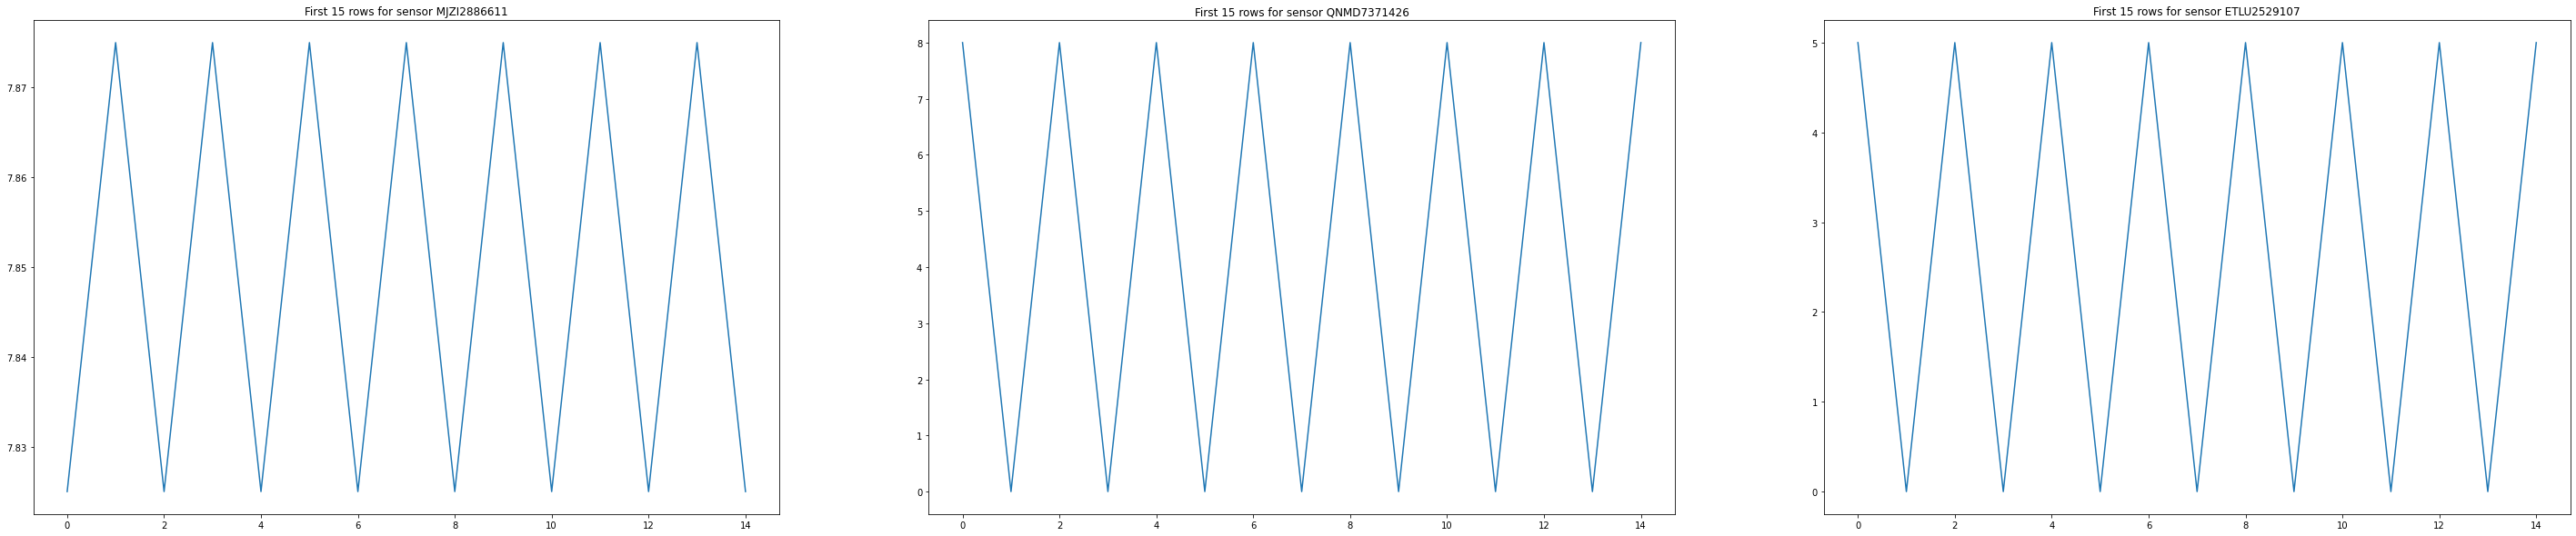

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (50, 10))
for i, tag in enumerate(['MJZI2886611', 'QNMD7371426', 'ETLU2529107']):
    sensor = df[df['Tag'] == tag]
    title= 'First 15 rows for sensor {}'.format(sensor['Tag'].mode()[0])
    ax[i].plot(sensor.reset_index()['avg'][:15])
    ax[i].title.set_text(title)
                                                
fig.savefig('categorical_sensors_plot.png')

### Investigatging the temperature sensor with 3 values

In [16]:
three_values = df[df['Tag'].isin(['MJZI2886611'])]
print(three_values['avg'].value_counts())
three_values

7.875    1188
7.825    1171
7.900       1
Name: avg, dtype: int64


Tag                  TS    avg          UoM
85      MJZI2886611 2020-06-12 00:01:25  7.825  temperature
95      MJZI2886611 2020-06-12 00:01:30  7.875  temperature
1746    MJZI2886611 2020-06-12 00:08:35  7.825  temperature
1782    MJZI2886611 2020-06-12 00:08:45  7.875  temperature
1815    MJZI2886611 2020-06-12 00:09:00  7.825  temperature
...             ...                 ...    ...          ...
286979  MJZI2886611 2020-06-13 06:21:40  7.875  temperature
288983  MJZI2886611 2020-06-13 06:34:55  7.825  temperature
288986  MJZI2886611 2020-06-13 06:35:00  7.875  temperature
390490  MJZI2886611 2020-06-13 17:15:35  7.900  temperature
390515  MJZI2886611 2020-06-13 17:15:40  7.875  temperature

[2360 rows x 4 columns]

In [17]:
three_values['TS'].diff().value_counts()

00:00:05    1092
00:00:10     427
00:00:15     232
00:00:20     116
00:00:25      94
            ... 
00:09:00       1
00:09:40       1
00:10:20       1
00:13:40       1
00:12:15       1
Name: TS, Length: 105, dtype: int64

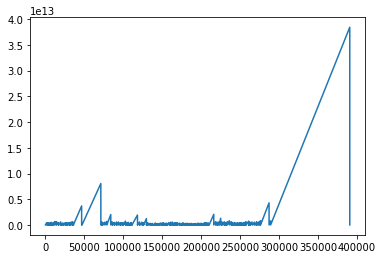

In [18]:
plt.plot(three_values['TS'].diff()[1:])

The sensor seems to be missing data at the end of the 48 hours, but seems normal otherwise

### Investigating the sensors with 31 rows

In [19]:
info[info['Number of Rows'] == 31]

Number of Rows  Unique Values Unit of Meassure
Tag                                                        
GRWS2213993              31              2      categorical
HEOV5851414              31              2      categorical
JWYX3983879              31              2      categorical
MIPD6103611              31              2      categorical
NYZP9283896              31              2      categorical
RJYE7545561              31              2      categorical
WWEF2365546              31              2      categorical
YUQQ6684067              31              2      categorical

In [20]:
df[df['Tag'].isin(info[info['Number of Rows'] == 31].index)]['TS'].value_counts()

2020-06-13 14:14:10    8
2020-06-12 18:59:25    8
2020-06-13 14:14:50    8
2020-06-13 19:45:15    8
2020-06-12 03:26:45    8
2020-06-13 18:32:35    8
2020-06-12 03:27:50    8
2020-06-13 08:47:05    8
2020-06-13 17:57:00    8
2020-06-13 17:57:20    8
2020-06-13 18:38:55    8
2020-06-13 18:40:10    8
2020-06-13 07:18:20    8
2020-06-13 15:42:45    8
2020-06-13 15:43:25    8
2020-06-13 07:14:25    8
2020-06-13 18:31:20    8
2020-06-13 20:04:10    8
2020-06-12 11:42:20    8
2020-06-12 11:42:55    8
2020-06-13 18:46:40    8
2020-06-12 15:23:50    8
2020-06-12 15:24:35    8
2020-06-12 13:35:35    8
2020-06-12 13:36:10    8
2020-06-12 11:11:25    8
2020-06-12 11:11:55    8
2020-06-13 18:52:00    8
2020-06-13 12:21:15    8
2020-06-13 12:22:05    8
2020-06-13 08:44:50    8
Name: TS, dtype: int64

All of the rows for these categorical sensors seem to have the same timestamps

### Investigating the information about different Units of Meassure (UoM)

In [21]:
info['Unit of Meassure'].value_counts()

flow           19
categorical    15
0              10
temperature     7
percentage      6
pressure        3
frequency       2
current         1
time            1
number          1
Name: Unit of Meassure, dtype: int64

In [22]:
info.groupby('Unit of Meassure')['Number of Rows'].sum()

Unit of Meassure
0               28207
categorical      4349
current         19687
flow           197845
frequency        2047
number           1004
percentage      76419
pressure        55367
temperature     55472
time             7112
Name: Number of Rows, dtype: int64

In [23]:
info[info['Unit of Meassure'].isin(info['Unit of Meassure'].value_counts().tail(5).index)]

Number of Rows  Unique Values Unit of Meassure
Tag                                                        
BCNT5607274           19687          12827          current
CJYY7281535           19299          14086         pressure
CVKK2848713           12387           3100         pressure
GHWP1757707            7112           6565             time
JAAM9433816            1538            997        frequency
NLFD6046949           23681           8358         pressure
TJLA6041869            1004            317           number
UUFO3180241             509            252        frequency

#### Investigating the time sensor

In [24]:
df[df['Tag'] == 'GHWP1757707']

Tag                  TS      avg   UoM
201     GHWP1757707 2020-06-12 00:02:05  31.0840  time
228     GHWP1757707 2020-06-12 00:02:10  28.7512  time
248     GHWP1757707 2020-06-12 00:02:15  28.1212  time
273     GHWP1757707 2020-06-12 00:02:20  25.6592  time
304     GHWP1757707 2020-06-12 00:02:25  24.0040  time
...             ...                 ...      ...   ...
447228  GHWP1757707 2020-06-13 23:59:00  33.6972  time
447258  GHWP1757707 2020-06-13 23:59:05  34.1200  time
447287  GHWP1757707 2020-06-13 23:59:10  34.5940  time
447340  GHWP1757707 2020-06-13 23:59:20  35.4892  time
447417  GHWP1757707 2020-06-13 23:59:35  35.8992  time

[7112 rows x 4 columns]

The sensor doesn't seem to have anything wierd going on

# Preprocessing the data

In [25]:
indices = pd.date_range(start='2020-06-12', end = '2020-06-14', freq = '5s')
full_time = pd.DataFrame(index = indices)
full_time

Empty DataFrame
Columns: []
Index: [2020-06-12 00:00:00, 2020-06-12 00:00:05, 2020-06-12 00:00:10, 2020-06-12 00:00:15, 2020-06-12 00:00:20, 2020-06-12 00:00:25, 2020-06-12 00:00:30, 2020-06-12 00:00:35, 2020-06-12 00:00:40, 2020-06-12 00:00:45, 2020-06-12 00:00:50, 2020-06-12 00:00:55, 2020-06-12 00:01:00, 2020-06-12 00:01:05, 2020-06-12 00:01:10, 2020-06-12 00:01:15, 2020-06-12 00:01:20, 2020-06-12 00:01:25, 2020-06-12 00:01:30, 2020-06-12 00:01:35, 2020-06-12 00:01:40, 2020-06-12 00:01:45, 2020-06-12 00:01:50, 2020-06-12 00:01:55, 2020-06-12 00:02:00, 2020-06-12 00:02:05, 2020-06-12 00:02:10, 2020-06-12 00:02:15, 2020-06-12 00:02:20, 2020-06-12 00:02:25, 2020-06-12 00:02:30, 2020-06-12 00:02:35, 2020-06-12 00:02:40, 2020-06-12 00:02:45, 2020-06-12 00:02:50, 2020-06-12 00:02:55, 2020-06-12 00:03:00, 2020-06-12 00:03:05, 2020-06-12 00:03:10, 2020-06-12 00:03:15, 2020-06-12 00:03:20, 2020-06-12 00:03:25, 2020-06-12 00:03:30, 2020-06-12 00:03:35, 2020-06-12 00:03:40, 2020-06-12 00:03:45, 2020-06-12 00:03:50, 2020-06-12 00:03:55, 2020-06-12 00:04:00, 2020-06-12 00:04:05, 2020-06-12 00:04:10, 2020-06-12 00:04:15, 2020-06-12 00:04:20, 2020-06-12 00:04:25, 2020-06-12 00:04:30, 2020-06-12 00:04:35, 2020-06-12 00:04:40, 2020-06-12 00:04:45, 2020-06-12 00:04:50, 2020-06-12 00:04:55, 2020-06-12 00:05:00, 2020-06-12 00:05:05, 2020-06-12 00:05:10, 2020-06-12 00:05:15, 2020-06-12 00:05:20, 2020-06-12 00:05:25, 2020-06-12 00:05:30, 2020-06-12 00:05:35, 2020-06-12 00:05:40, 2020-06-12 00:05:45, 2020-06-12 00:05:50, 2020-06-12 00:05:55, 2020-06-12 00:06:00, 2020-06-12 00:06:05, 2020-06-12 00:06:10, 2020-06-12 00:06:15, 2020-06-12 00:06:20, 2020-06-12 00:06:25, 2020-06-12 00:06:30, 2020-06-12 00:06:35, 2020-06-12 00:06:40, 2020-06-12 00:06:45, 2020-06-12 00:06:50, 2020-06-12 00:06:55, 2020-06-12 00:07:00, 2020-06-12 00:07:05, 2020-06-12 00:07:10, 2020-06-12 00:07:15, 2020-06-12 00:07:20, 2020-06-12 00:07:25, 2020-06-12 00:07:30, 2020-06-12 00:07:35, 2020-06-12 00:07:40, 2020-06-12 00:07:45, 2020-06-12 00:07:50, 2020-06-12 00:07:55, 2020-06-12 00:08:00, 2020-06-12 00:08:05, 2020-06-12 00:08:10, 2020-06-12 00:08:15, ...]

[34561 rows x 0 columns]

In [26]:
sensors = df.copy()
sensors = sensors.groupby(['Tag'], as_index=True).apply(lambda x: full_time.merge(x.set_index('TS').asfreq('5s').reset_index(), how='left', left_index=True, right_on='TS'))
sensors

TS  Tag  avg  UoM
Tag                                               
ACSH9824768 NaN 2020-06-12 00:00:00  NaN  NaN  NaN
            NaN 2020-06-12 00:00:05  NaN  NaN  NaN
            NaN 2020-06-12 00:00:10  NaN  NaN  NaN
            NaN 2020-06-12 00:00:15  NaN  NaN  NaN
            NaN 2020-06-12 00:00:20  NaN  NaN  NaN
...                             ...  ...  ...  ...
YUQQ6684067 NaN 2020-06-13 23:59:40  NaN  NaN  NaN
            NaN 2020-06-13 23:59:45  NaN  NaN  NaN
            NaN 2020-06-13 23:59:50  NaN  NaN  NaN
            NaN 2020-06-13 23:59:55  NaN  NaN  NaN
            NaN 2020-06-14 00:00:00  NaN  NaN  NaN

[2246465 rows x 4 columns]

### filling in empty tag and UoM

In [27]:
for tag, data in sensors.groupby(level=0):
    sensors.loc[tag, 'Tag'] = tag
    sensors.loc[tag, 'UoM'] = data['UoM'].mode()[0]

C:\Users\Funk\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [28]:
sensors

TS          Tag  avg          UoM
Tag                                                               
ACSH9824768 NaN 2020-06-12 00:00:00  ACSH9824768  NaN         flow
            NaN 2020-06-12 00:00:05  ACSH9824768  NaN         flow
            NaN 2020-06-12 00:00:10  ACSH9824768  NaN         flow
            NaN 2020-06-12 00:00:15  ACSH9824768  NaN         flow
            NaN 2020-06-12 00:00:20  ACSH9824768  NaN         flow
...                             ...          ...  ...          ...
YUQQ6684067 NaN 2020-06-13 23:59:40  YUQQ6684067  NaN  categorical
            NaN 2020-06-13 23:59:45  YUQQ6684067  NaN  categorical
            NaN 2020-06-13 23:59:50  YUQQ6684067  NaN  categorical
            NaN 2020-06-13 23:59:55  YUQQ6684067  NaN  categorical
            NaN 2020-06-14 00:00:00  YUQQ6684067  NaN  categorical

[2246465 rows x 4 columns]

## Evaluating different interpolation techniques

In [43]:
def plotInterpolation(keys):
    fig, ax = plt.subplots(len(keys), 2, figsize = (50, len(keys) * 10))

    for i, key in enumerate(keys):
        one_sensor = sensors.loc[(key, slice(None)), :]
#         one_sensor_interpol = one_sensor.set_index('TS').resample('5s').mean().interpolate()
        one_sensor_interpol = one_sensor.set_index('TS').resample('5s').mean().interpolate(limit_area='outside', method='quadratic', order=3).interpolate()
        one_sensor_new_interpol = one_sensor.set_index('TS').resample('5s').mean().interpolate(method='nearest')
#         one_sensor_ffill = one_sensor.set_index('TS').fillna(method='ffill') #nterpolate(method='linear', limit_direction='forward', axis=0)
        one_sensor_backfill = one_sensor.set_index('TS').fillna(method='backfill')

        ax[i, 0].title.set_text('{} original'.format(key))
        ax[i, 1].title.set_text('{} interpolated'.format(key))
#         ax[i, 2].title.set_text('{} forward filled'.format(key))
#         ax[i, 2].title.set_text('{} backward filled'.format(key))
        

        ax[i, 0].plot(one_sensor.set_index('TS')['avg'].head(2000))
        ax[i, 1].plot(one_sensor_interpol['avg'].head(2000))
#         ax[i, 2].plot(one_sensor_new_interpol['avg'].head(1000))
#         ax[i, 3].plot(one_sensor_backfill['avg'].head(1000))

    fig.savefig('interpolation_example.png')
        

## Most Frequent keys

Index(['CCUA4846210', 'NLFD6046949', 'IBCD9076387', 'BCNT5607274',
       'CJYY7281535', 'XZWH6517900', 'KUBF4965544', 'ITPL9140030',
       'YQIV8384792', 'WJTY3058662'],
      dtype='object')


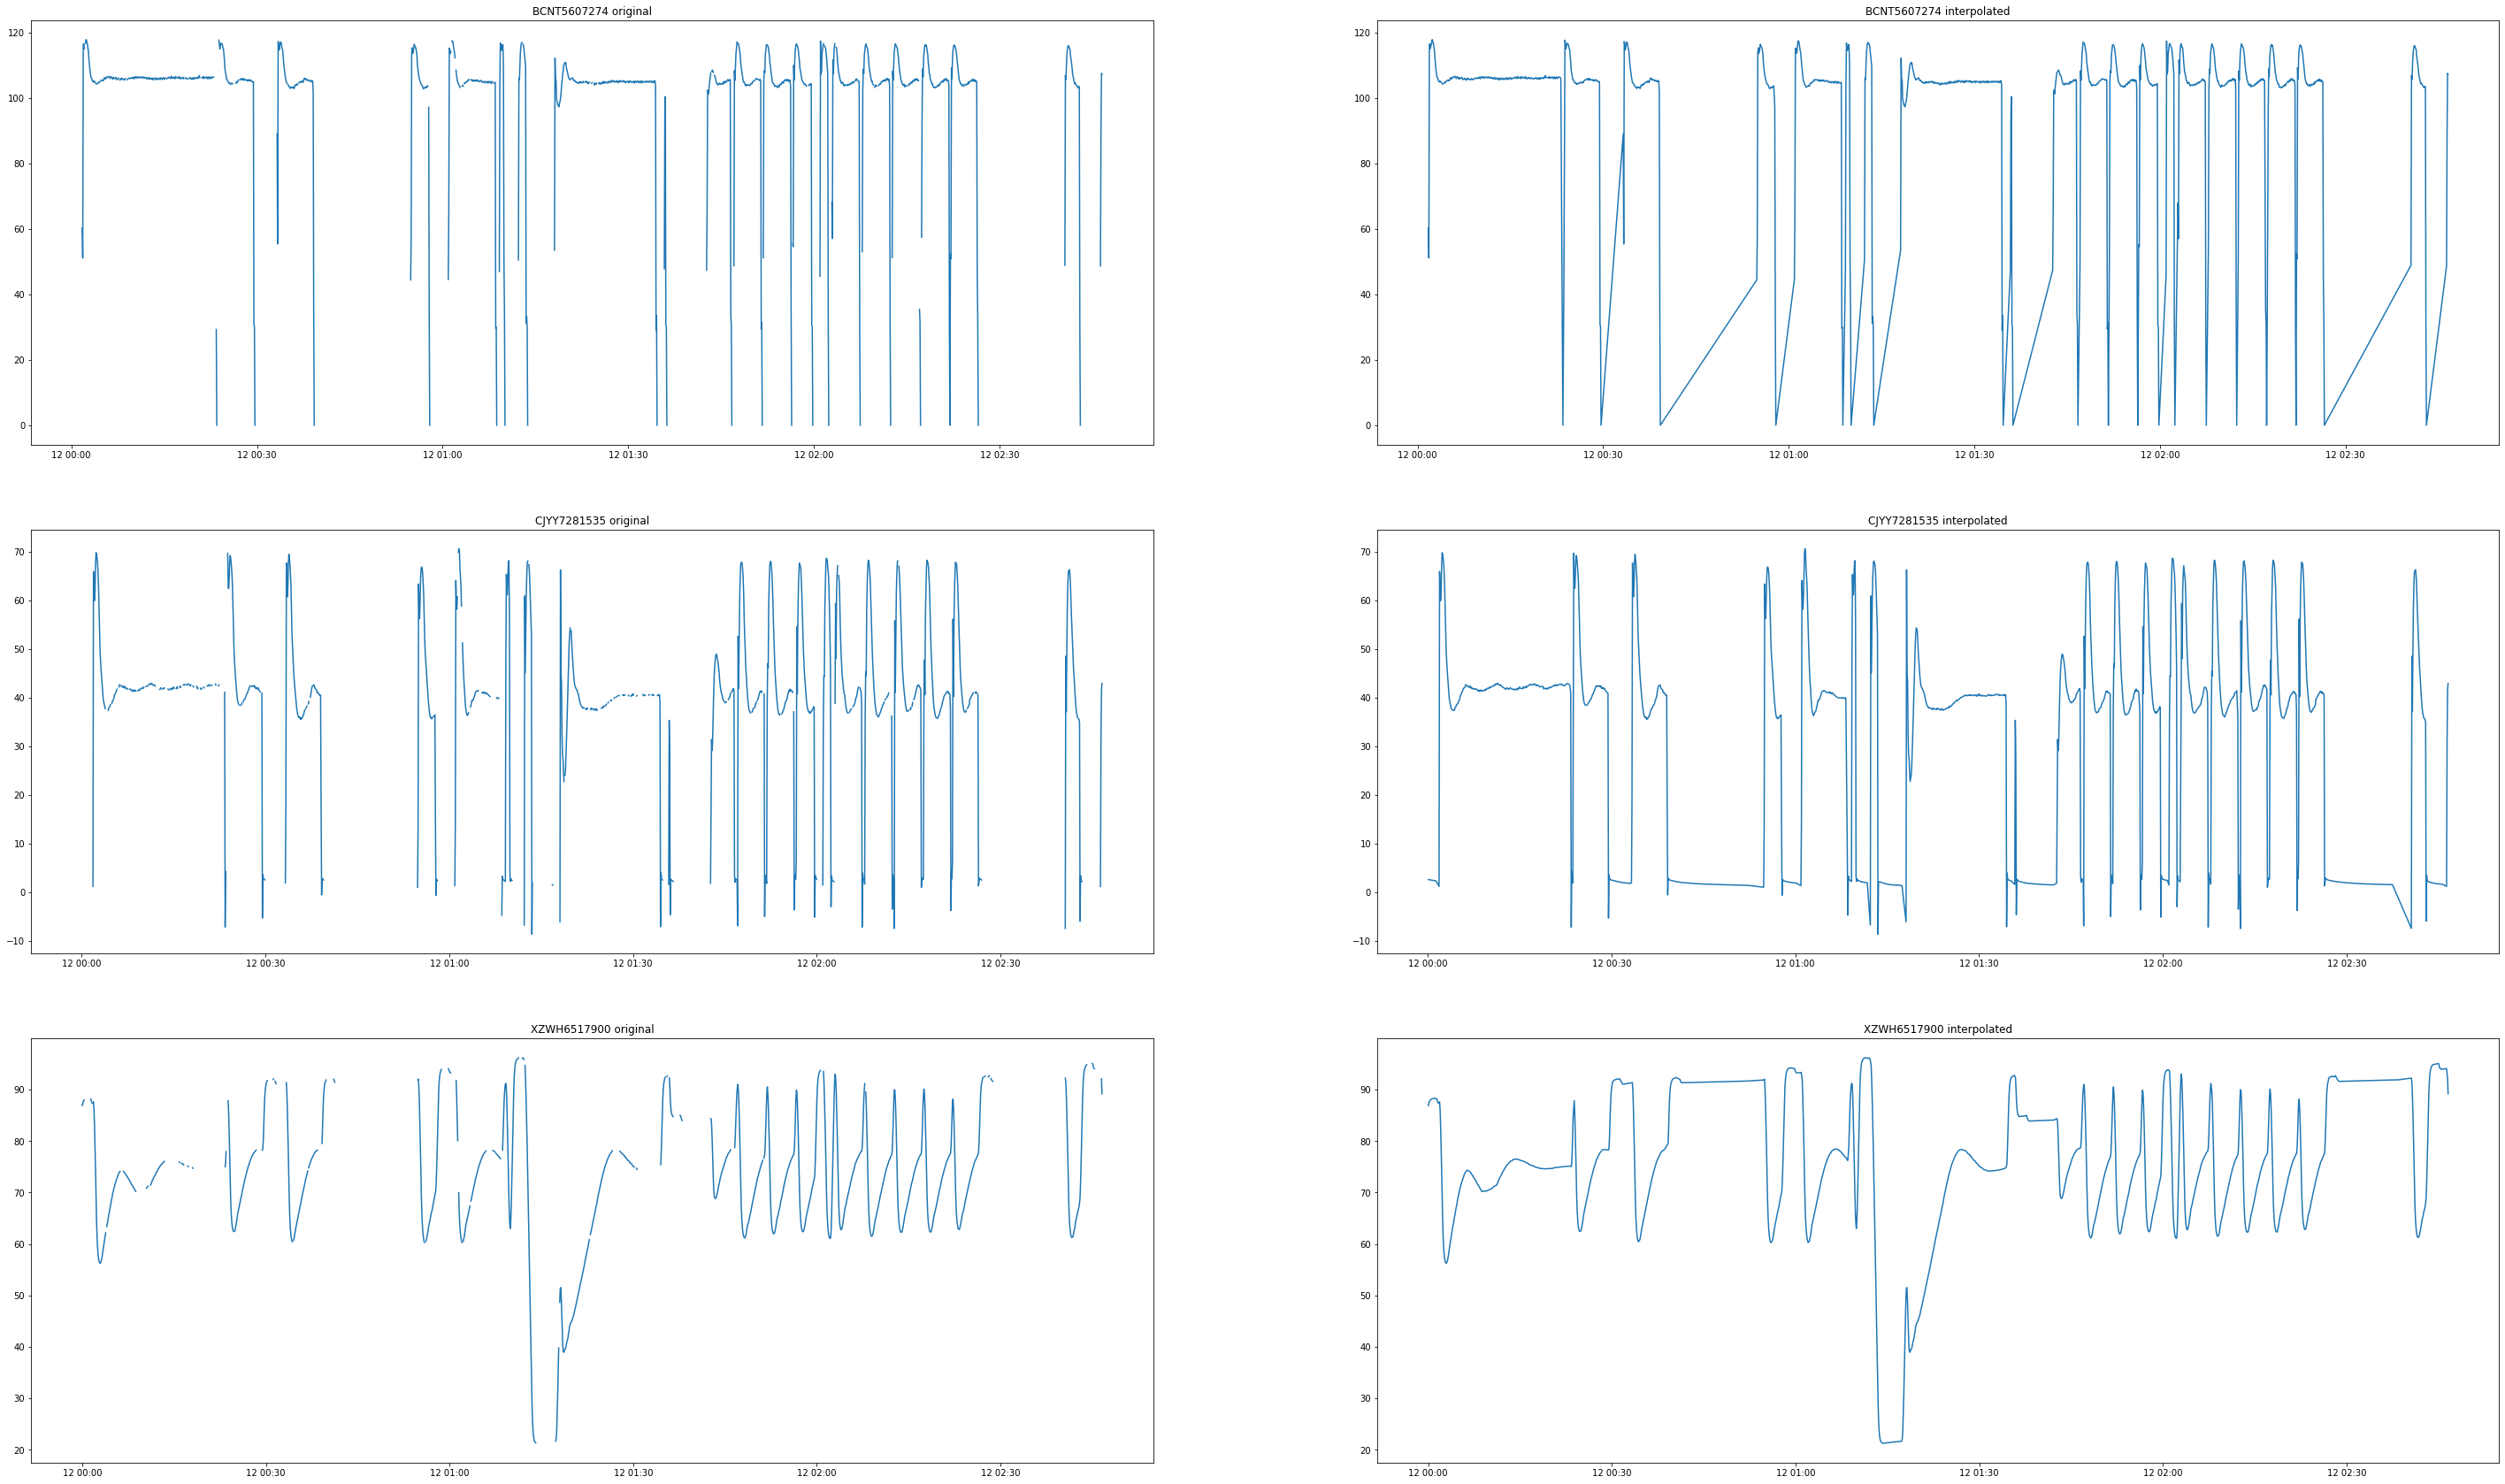

In [57]:
most_frequent_keys = df['Tag'].value_counts().head(10).keys()
print(most_frequent_keys)
plotInterpolation(most_frequent_keys[3:6])

## Flow Sensors

Index(['CCUA4846210', 'YQIV8384792', 'WJTY3058662', 'UBDD6270540',
       'OGXF8790955', 'WECE8118101', 'TPDS7991137', 'OPTP4622826',
       'OBVY4087560', 'UEDA3063294'],
      dtype='object')


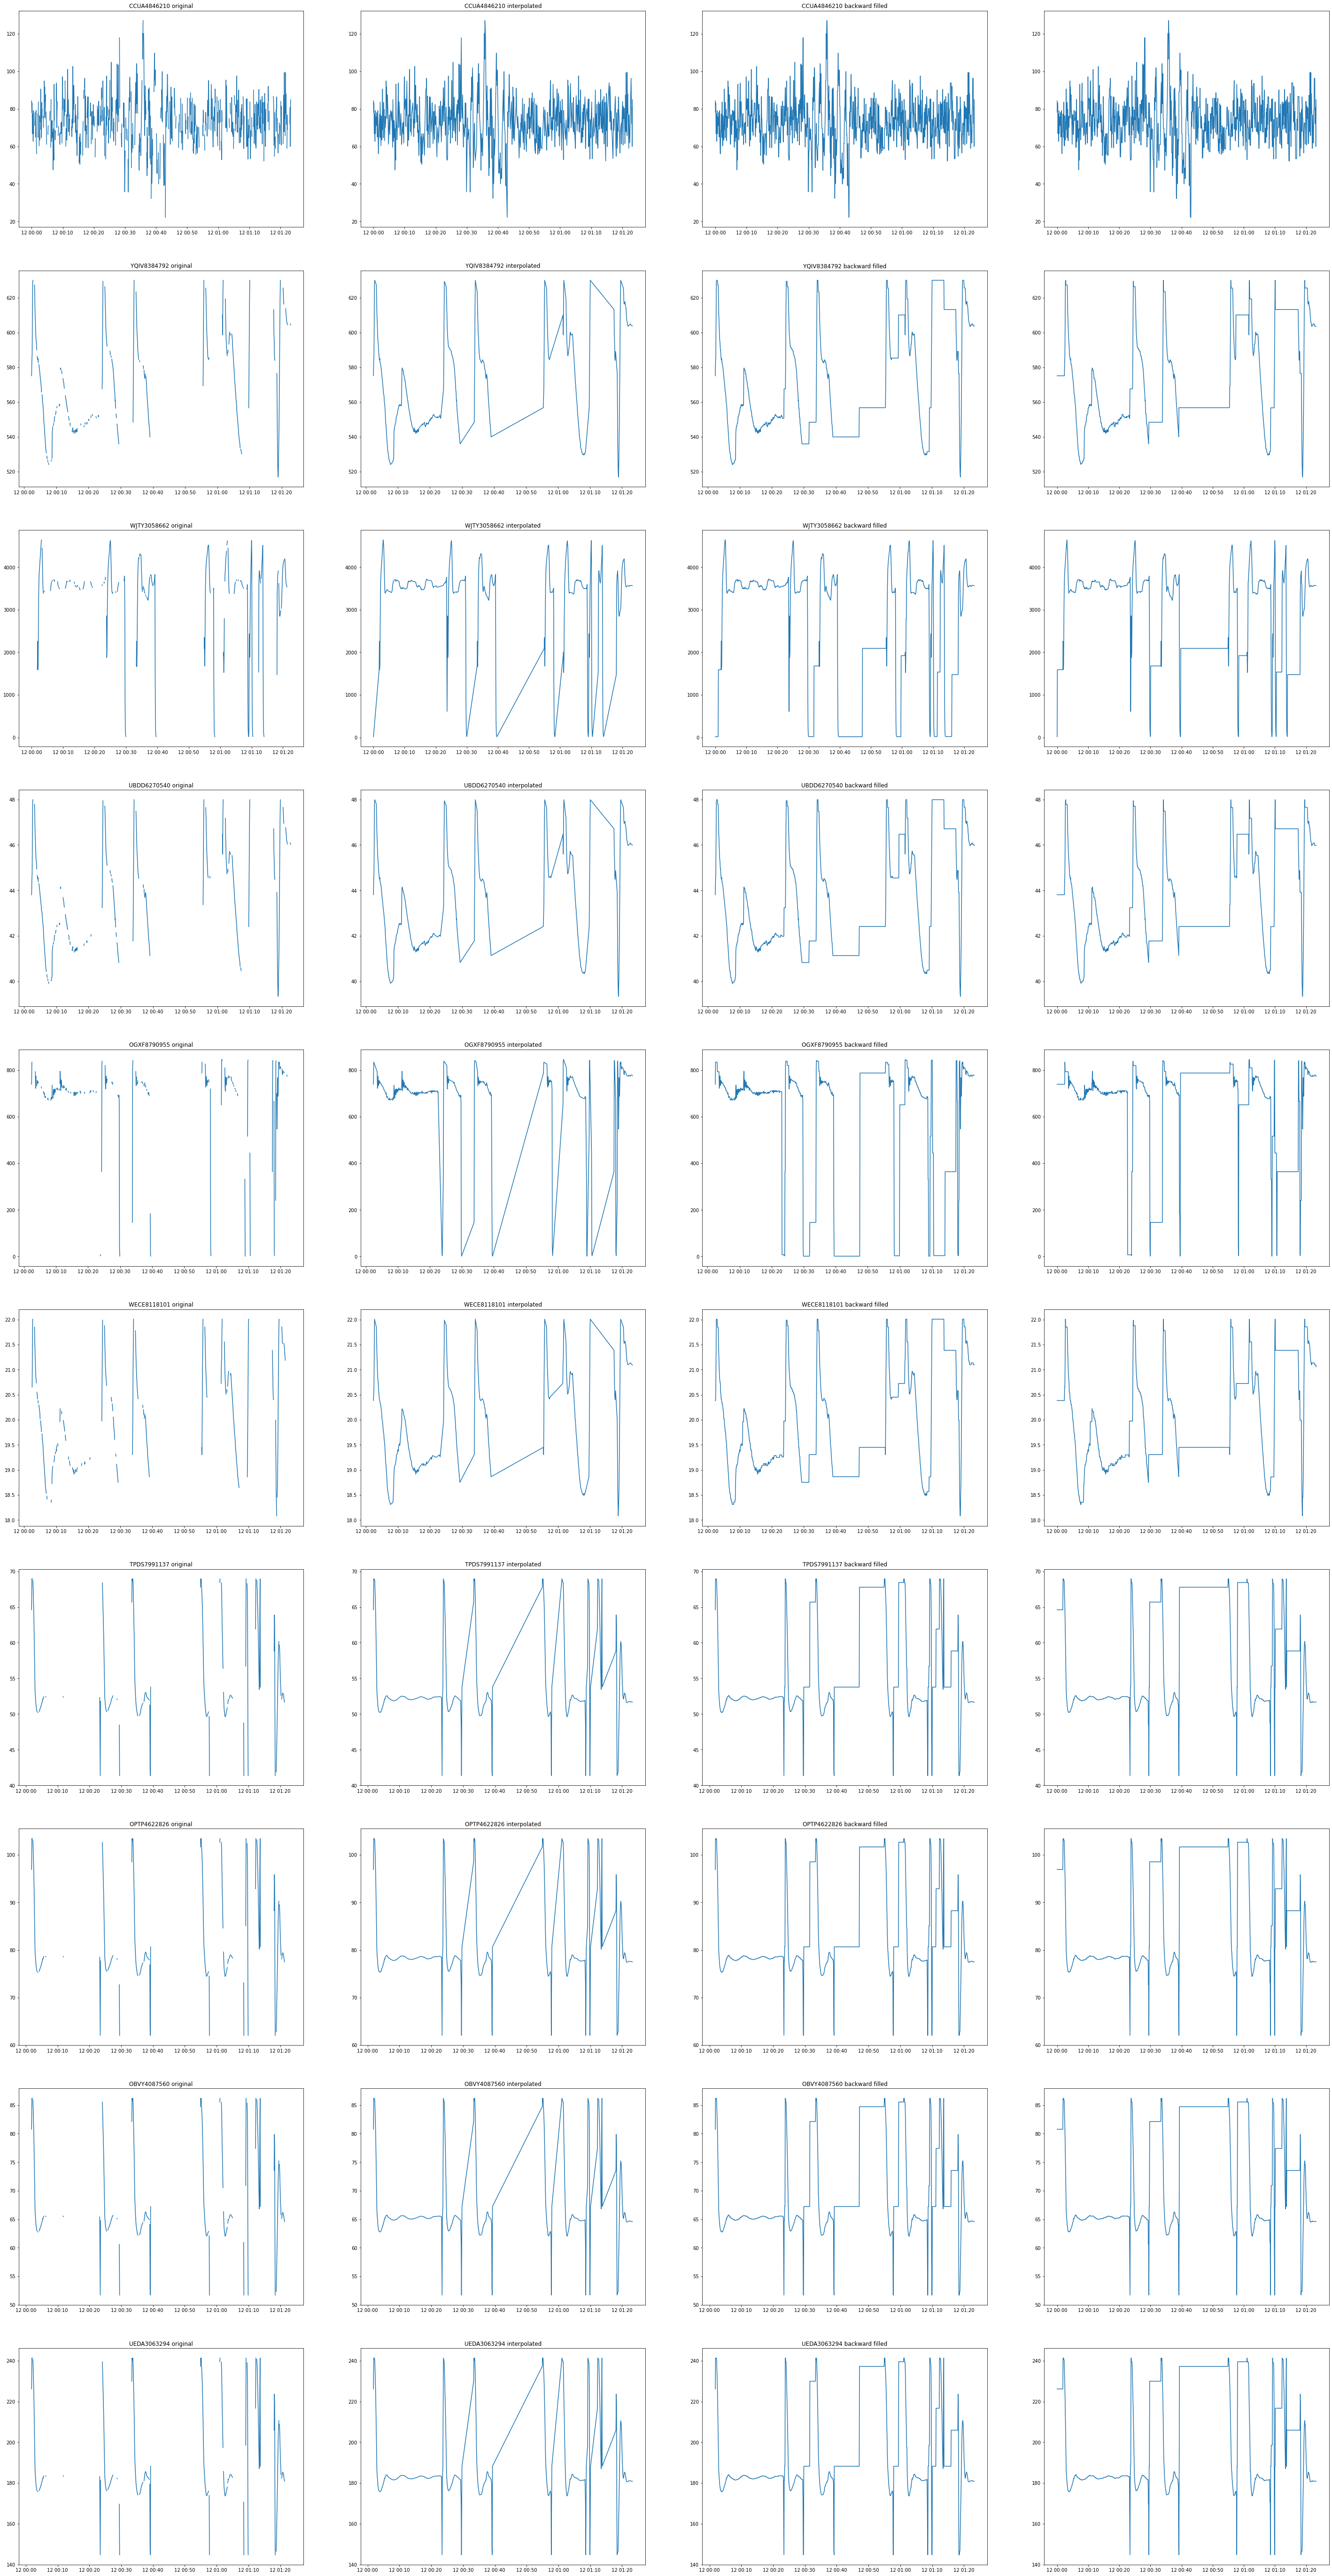

In [47]:
flow_keys = df[df['UoM'] == 'flow']['Tag'].value_counts().head(10).keys()
print(flow_keys)
plotInterpolation(flow_keys)

## Percentage sensors

Index(['XZWH6517900', 'ITPL9140030', 'FRMT5013249', 'GAOJ1253882',
       'FIFW7229404', 'GZBG5070510'],
      dtype='object')


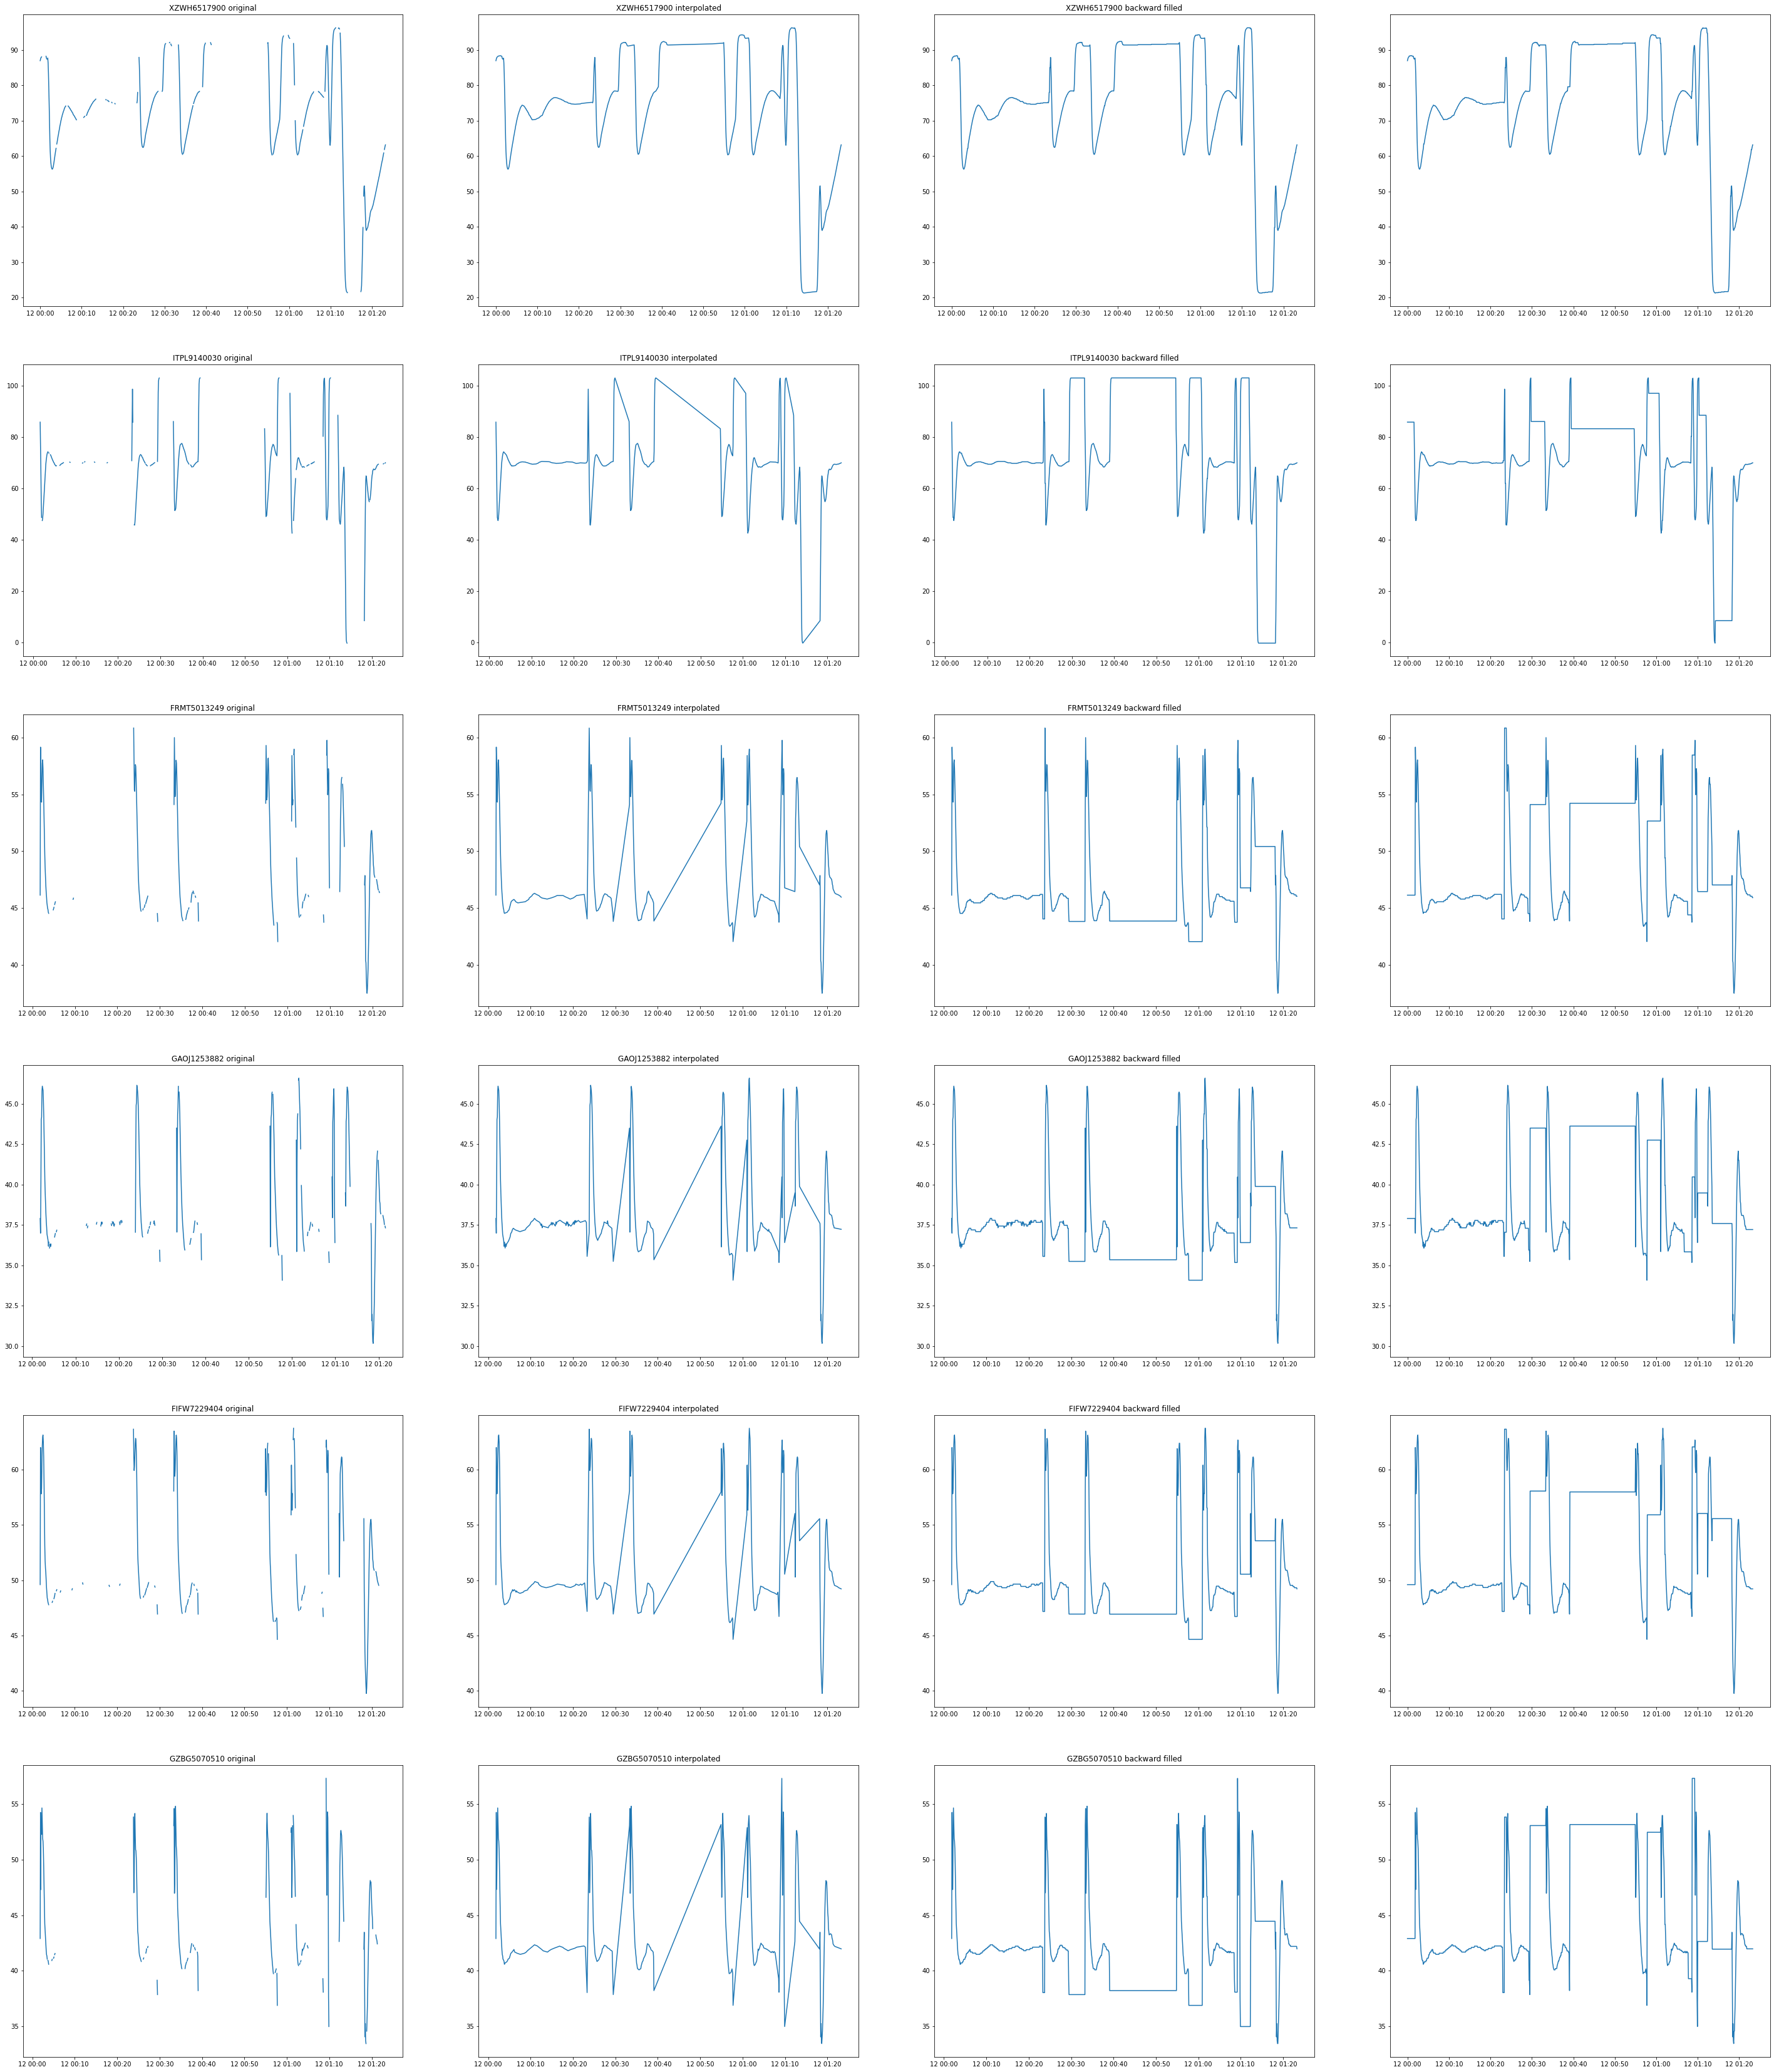

In [27]:
percentage_keys = df[df['UoM'] == 'percentage']['Tag'].value_counts().head(10).keys()
print(percentage_keys)
plotInterpolation(percentage_keys)

## Temperature sensors

Index(['IBCD9076387', 'OLGF7428100', 'RYSR5117035', 'VKBD2463131',
       'WFVO6119956', 'MJZI2886611', 'VOJU5732246'],
      dtype='object')


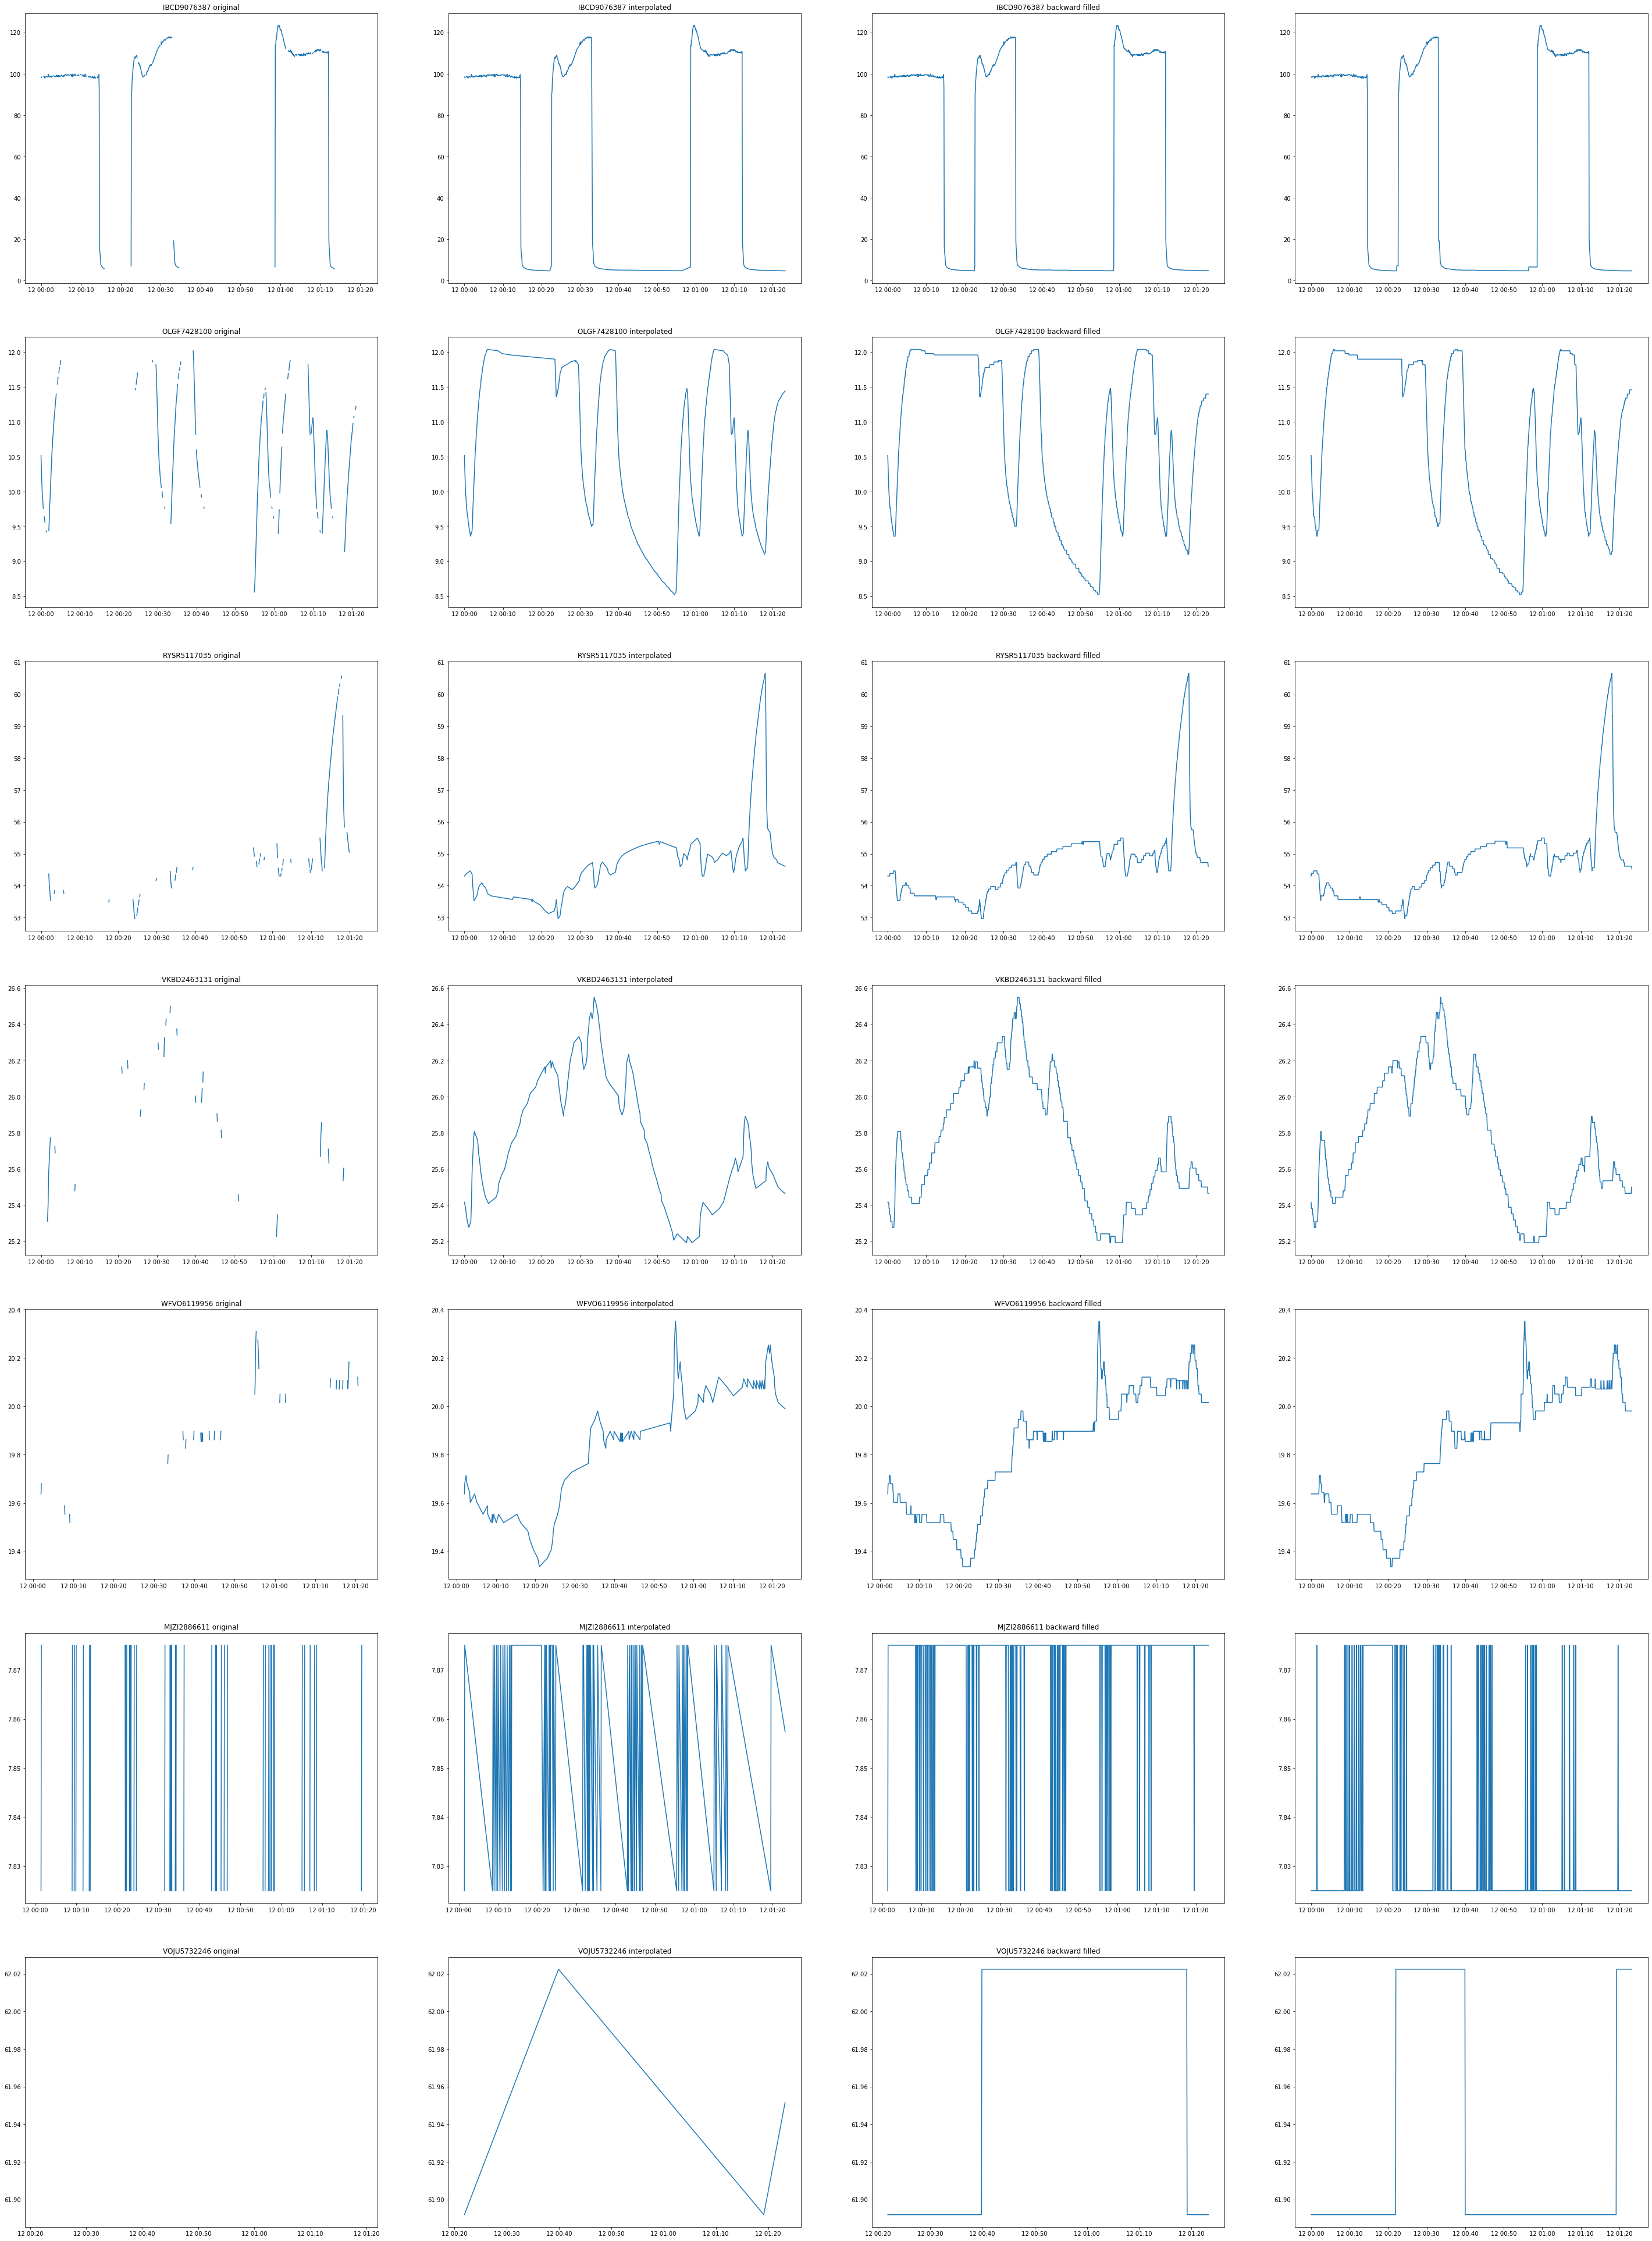

In [28]:
temperature_keys = df[df['UoM'] == 'temperature']['Tag'].value_counts().head(10).keys()
print(temperature_keys)
plotInterpolation(temperature_keys)

## Categorical Sensors

Index(['ETLU2529107', 'QNMD7371426', 'AQNB3577758', 'SIJC9876029',
       'GNIJ8913002'],
      dtype='object')


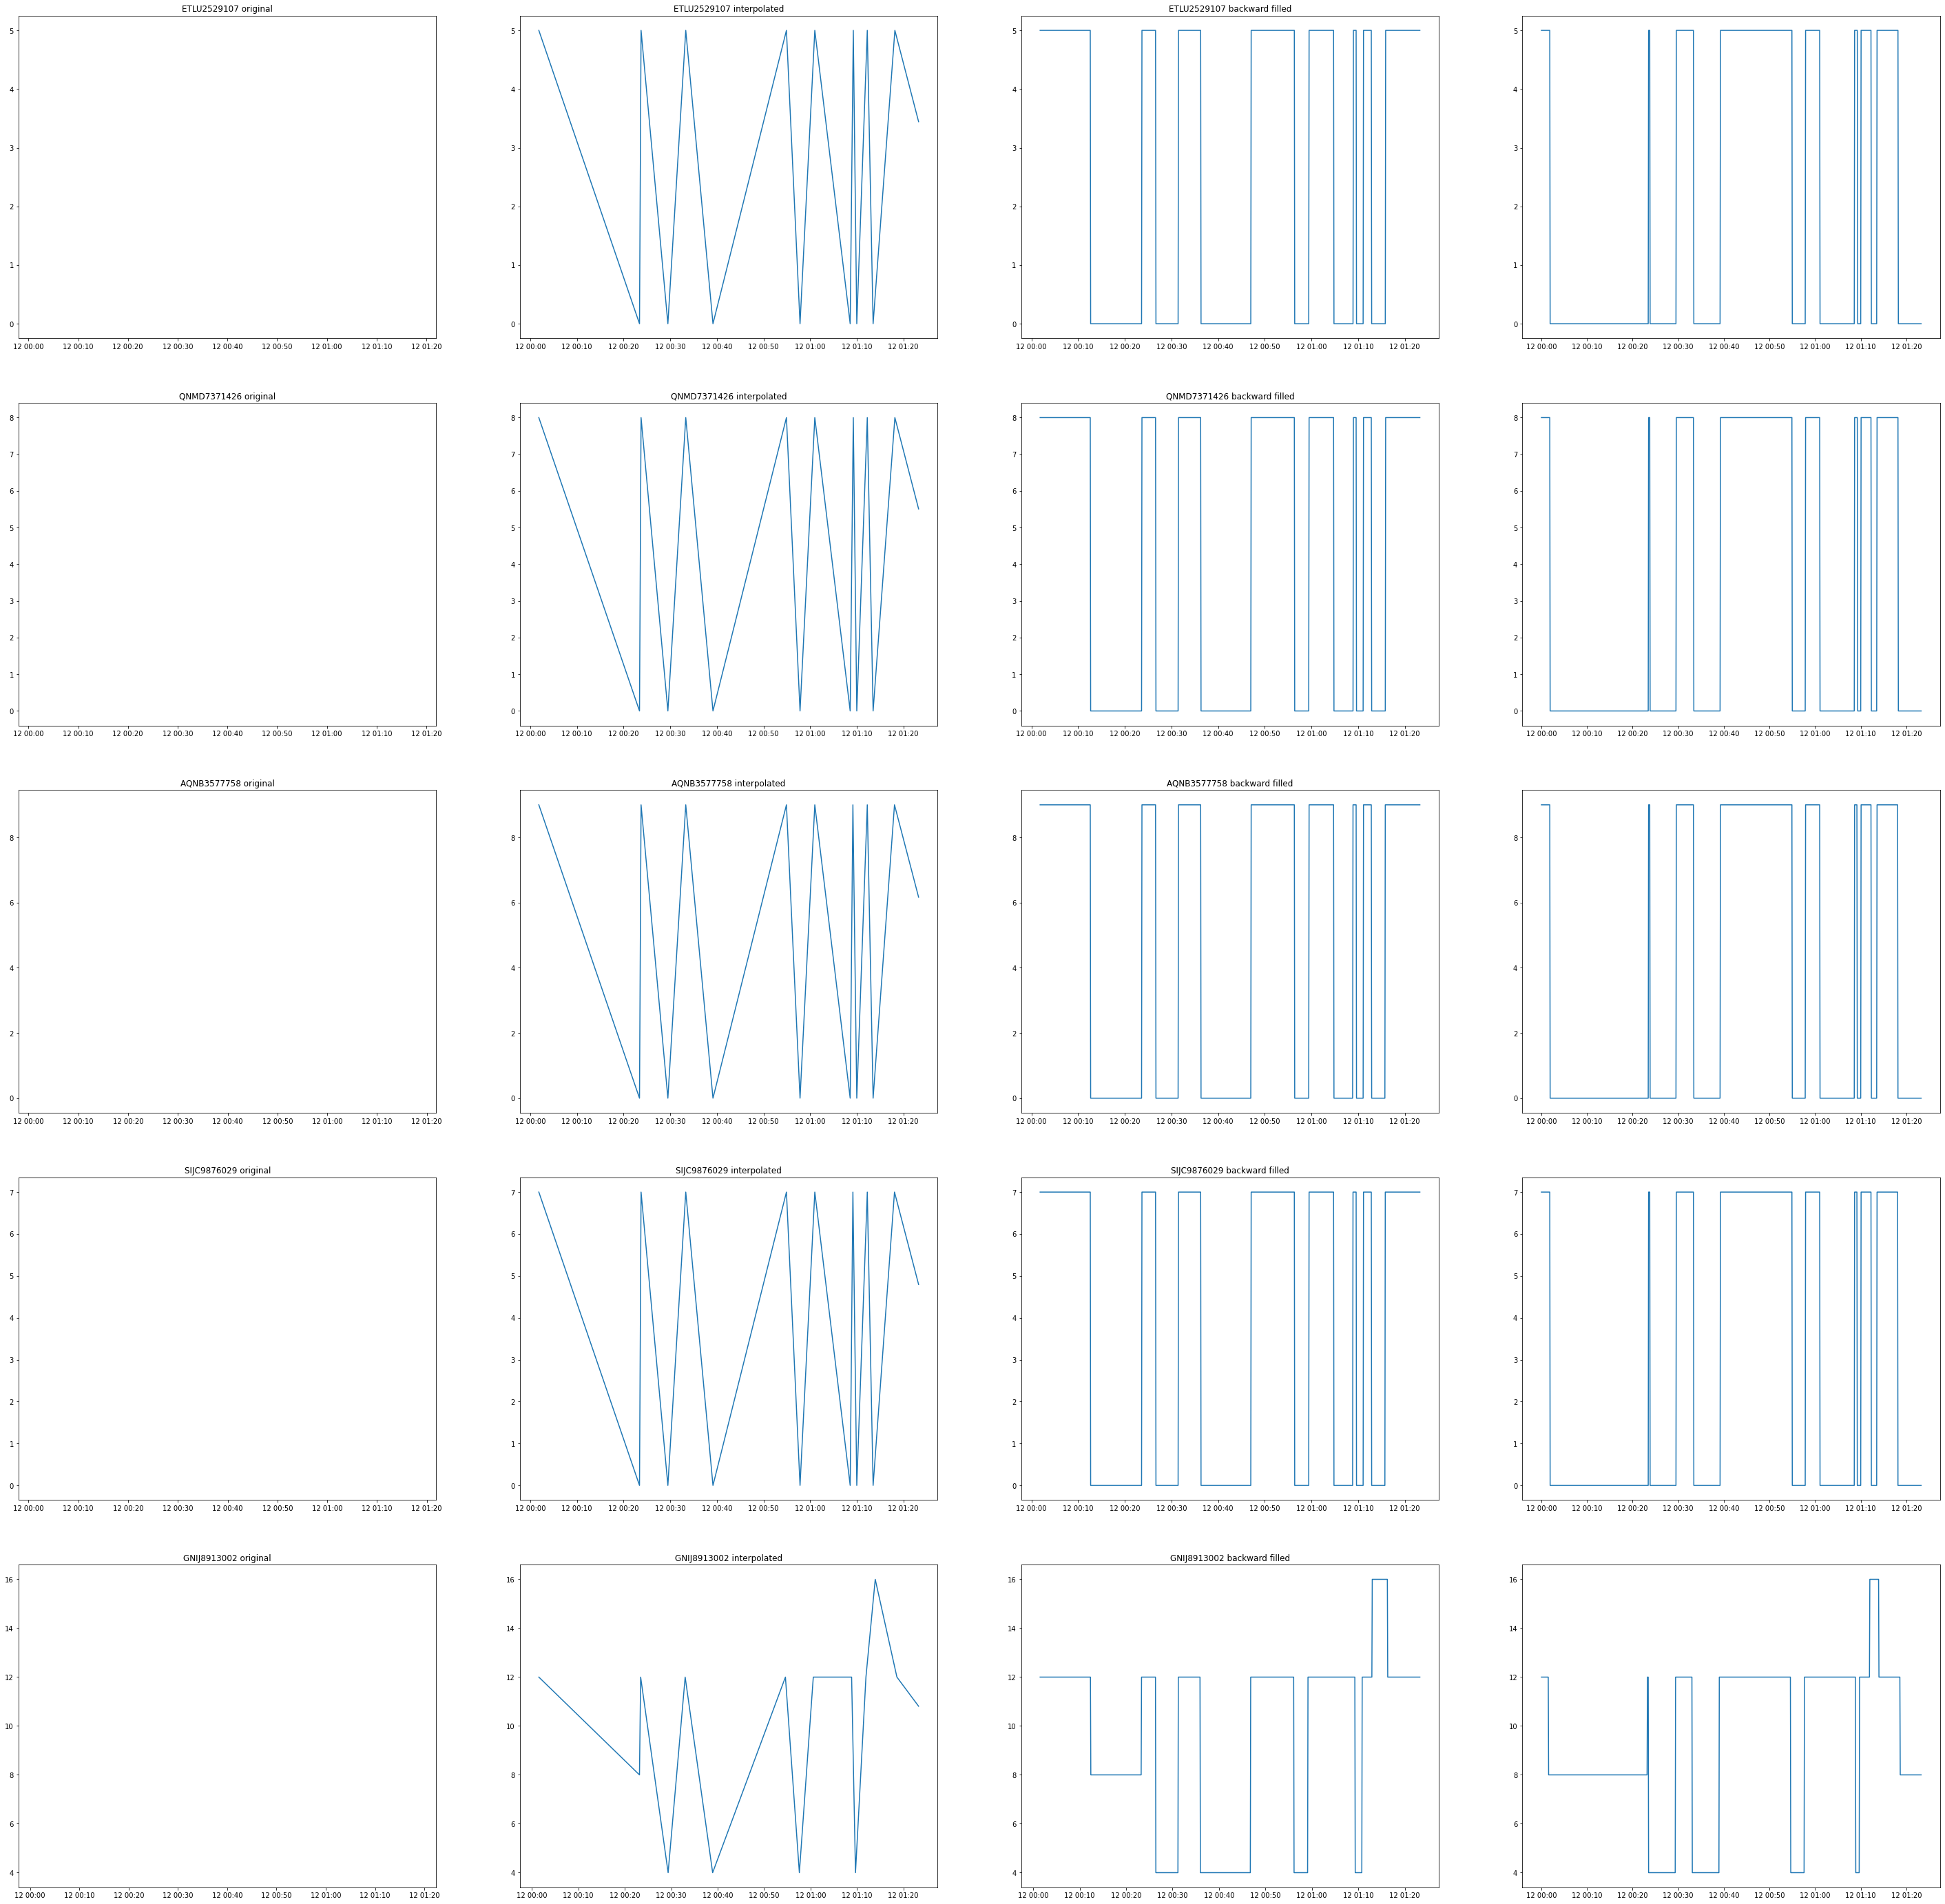

In [48]:
categorical_keys = df[df['UoM'] == 'categorical']['Tag'].value_counts().head(5).keys()
print(categorical_keys)
plotInterpolation(categorical_keys)

# Interpolation and exporting

In [30]:
## TODO argument the chosen interpolation techniques

In [31]:
def fill_categorical(sensor):
    values = sensor['avg'].value_counts().keys()
    first_valid_value = sensor.loc[sensor['avg'].first_valid_index()]['avg'][0]
    sensor = sensor.set_index('TS').fillna(method = "ffill").fillna(values[values != first_valid_value][0])
    return sensor

In [32]:
def export_interpolation(keys):
    data = pd.DataFrame(columns=df.columns)
    for key in keys:
        sensor = sensors.loc[(key, slice(None)), :]
        distinct_values = len(sensor['avg'].value_counts())
        if sensor['UoM'].mode()[0] == 'categorical' or  distinct_values <= 5:
            sensor_interpol = fill_categorical(sensor)
        else:
            sensor_interpol = sensor.set_index('TS').resample('5s').mean().interpolate(limit_area='outside', method='quadratic', order=3).interpolate()
        
        sensor_interpol['TS'] = sensor_interpol.index
        sensor_interpol['Tag'] = key
        sensor_interpol['UoM'] = sensor['UoM'].mode()[0]
        data = data.append(sensor_interpol, ignore_index = True)
        
    data.to_csv("data/interpolated_sensors.csv", index= False)
    return data

keys_to_export = df['Tag'].value_counts().keys()

data = export_interpolation(keys_to_export)
save_interpolated_data(data)

<ipython-input-31-f54280267188>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_valid_value = sensor.loc[sensor['avg'].first_valid_index()]['avg'][0]


In [33]:
data.groupby('Tag').count() 

TS    avg    UoM
Tag                             
ACSH9824768  34561  34532  34561
ALKR8498842  34561  34561  34561
AQNB3577758  34561  34561  34561
BCNT5607274  34561  34540  34561
BXWS8009878  34561  34533  34561
...            ...    ...    ...
WWEF2365546  34561  34561  34561
XZWH6517900  34561  34561  34561
YHUJ9211611  34561  34546  34561
YQIV8384792  34561  34533  34561
YUQQ6684067  34561  34561  34561

[65 rows x 3 columns]